In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seatsvotes

In [3]:
house = seatsvotes.data.congress(geo=True)

In [4]:
grouper = house.assign(dem_votes = house.vote_share*house.turnout).groupby('year')

In [5]:
party_voteshare = grouper.dem_votes.sum() / grouper.turnout.sum()
party_average_voteshare = grouper.vote_share.mean()
party_seatshare = grouper.apply(lambda x: (x.vote_share > .5).mean())

Text(0,0.5,'% Seats won by Dems')

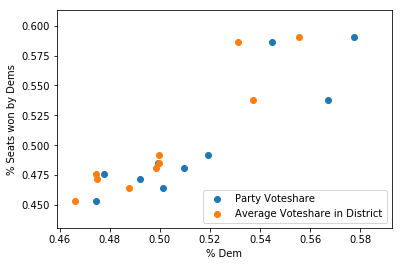

In [6]:
plt.scatter(party_average_voteshare, party_seatshare, 
            label='Party Voteshare')
plt.scatter(party_voteshare, party_seatshare, 
            label='Average Voteshare in District')
plt.legend()
plt.xlabel("% Dem")
plt.ylabel("% Seats won by Dems")

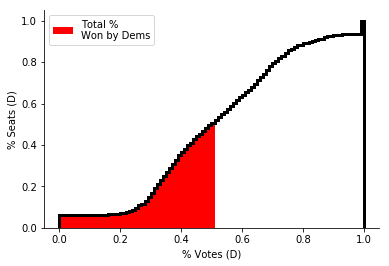

In [7]:
y,x,patches = plt.hist(house.dropna(subset=['vote_share']).vote_share.values, 
                         cumulative=True, density=True,
                         color='r', bins=100, linewidth=3,
                       label='Total % \nWon by Dems')
plt.hist(house.dropna(subset=['vote_share']).vote_share.values, 
                         cumulative=True, density=True, histtype='step',
                         color='k', bins=100, linewidth=3)
for xi,patch in zip(x,patches):
    if xi > .5:
        patch.set_color('none')
plt.xlabel("% Votes (D)")
plt.ylabel("% Seats (D)")
plt.legend()
sns.despine()
plt.show()

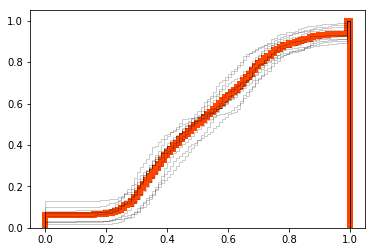

In [8]:
for year,chunk in house.groupby('year'):
    plt.hist(chunk.vote_share.dropna().values, 
                             cumulative=True, density=True, histtype='step',
                             color='k', bins=100, alpha=.2, zorder=1000)
plt.hist(house.dropna(subset=['vote_share']).vote_share.values, 
         cumulative=True, density=True, histtype='step',
         color='orangered', bins=100, linewidth=6)
plt.show()

# Uniform partisan swing

In [9]:
hope = house.query('year == 1992')\
                 .dropna(subset=['vote_share'])\
                 .vote_share.values

In [10]:
n = hope.shape[0]

Changes can only occur in more than $1/n$ increments. SO, the horizontal lines mark off each possible vertical value corresponding to a given voteshare in the district

(0.36, 0.47)

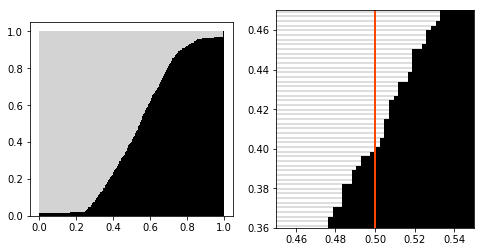

In [11]:
f,ax = plt.subplots(1,2,figsize=(8,4), subplot_kw=dict(aspect='equal'))
y,x,patches = ax[0].hist(hope, 
                         cumulative=True, density=True,
                         color='k', bins=n, linewidth=3,
                       label='Total % \nWon by Dems')
y,x,patches = ax[1].hist(hope, 
                         cumulative=True, density=True,
                         color='k', bins=n, linewidth=3,
                       label='Total % \nWon by Dems')
plt.vlines(.5,0,.5, color='orangered', linewidth=2)
ax[1].hlines(np.arange(0,n)/n,0,1, 
             color='lightgrey', 
             alpha=1, zorder=-1)
ax[0].hlines(np.arange(0,n)/n,0,1, 
             color='lightgrey', 
             alpha=1, zorder=-1)
plt.xlim(.45, .55)
plt.ylim(.36, .47)

if we assume that the average district voteshares slide forwards or backwards by a *uniform amount* (the assumption called the uniform partisan swing), then each of these changes will only move a single district at a time. 

So, under the assumption of uniform swing, this represents the relationship between the average vote share and the % of seats won. 

To get the actual seats-votes curve (in terms of party vote share, not average party vote) it is sufficient to shift this ecdf.

# This assumption is somewhat unrealistic given the data. 

In [20]:
aughties = house.query('year > 2000 & year < 2012')

In [22]:
aughties['district_id'] = aughties.state_fips.astype(str).str.rjust(2,'0') \
                        + aughties.lewis_dist.astype(str).str.rjust(2, '0')

/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
swings = aughties.pivot(index='district_id', 
               columns='year', 
               values='vote_share').diff(axis=1).drop(2002,axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4c33f3be0>,
      dtype=object)

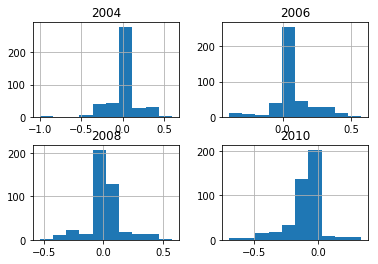

In [26]:
swings.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4c2c01da0>,
      dtype=object)

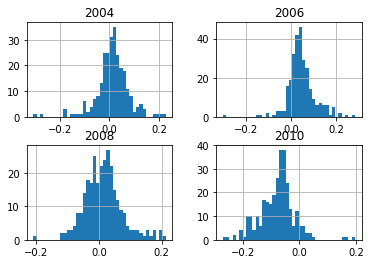

In [40]:
midswing = aughties.query('vote_share < .75 & vote_share > .25')\
                    .pivot(index='district_id', 
                           columns='year', 
                           values='vote_share')\
                    .diff(axis=1).drop(2002,axis=1)
midswing.hist(bins=40)

In [80]:
spswing = aughties.merge(midswing[2004].to_frame('swing'), 
                         left_on='district_id', 
                         right_index=True,how='left')
spswing = spswing.query('state_name not in ("alaska", "hawaii")')

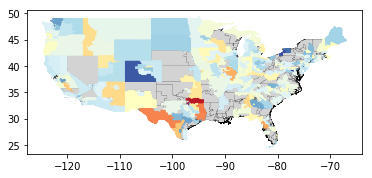

In [81]:
ax = spswing[~spswing.swing.isnull()].plot('swing', cmap='RdYlBu')
spswing[spswing.swing.isnull()].plot(color='lightgrey', edgecolor='k', 
                                     linewidth=.1, zorder=-1,ax=ax)

In [82]:
import pysal

/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [ ]:
Is = []
for y in np.arange(2004,2012,2):
    spswing = aughties.merge(midswing[y].to_frame('swing'), 
                         left_on='district_id', 
                         right_index=True,how='left')
    spswing = spswing.query('state_name not in ("alaska", "hawaii")')
    W = pysal.weights.Queen.from_dataframe(spswing, k=8)
    Is.append(pysal.Moran(spswing.swing.fillna(0), W))

In [ ]:
plt.errorbar(np.arange(2004,2012,2), 
             [mi.I for mi in Is],
             [mi.VI_rand**.5 for mi in Is],
             fmt='none', color='k')
plt.scatter(np.arange(2004,2012,2), 
             [mi.I for mi in Is], marker='x', color='r', zorder=100)
plt.xticks(np.arange(2004,2012,2))
sns.despine()
plt.xlabel("Moran's I for queen congressional district swings")